In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
with open(r"../Dataset/dataframe.pkl", 'rb') as fp:
    df=pickle.load(fp)
    
lower_bound = 1950
df = df[df['Time'] >= lower_bound]

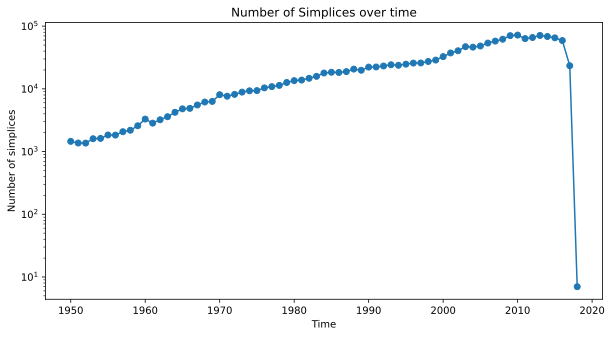

In [3]:
# We plot number of simplices over time
fig, ax = plt.subplots(figsize=(10, 5))
df.groupby("Time").count()["Simplices"].plot(ax=ax, marker="o")
plt.title("Number of Simplices over time")
plt.xlabel("Time")
plt.ylabel("Number of simplices")
plt.yscale("log")

In [4]:
df_i = df.explode("Simplices").reset_index()

In [5]:
# Now we treat Time column as a datetime object
import datetime

df_i['Time'] = pd.to_datetime(df_i['Time'], format='%Y')

# and we sort the dataframe by Time
df_i = df_i.sort_values(by='Time')

# Simplices as int
df_i["Simplices"] = df_i["Simplices"].astype(int)

### Number of simplices (papers) over time

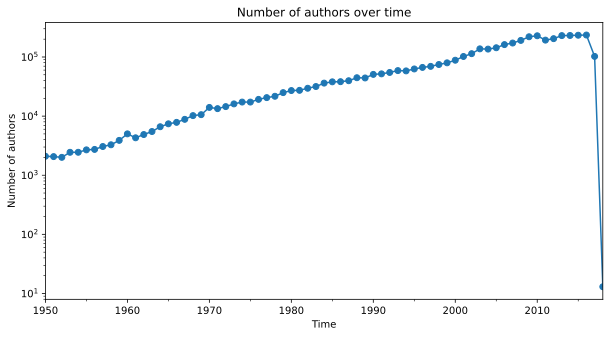

In [6]:
# We plot number of simplices over time
fig, ax = plt.subplots(figsize=(10, 5))
df_i.groupby("Time").count()["Simplices"].plot(ax=ax, marker="o")
plt.title("Number of authors over time")
plt.xlabel("Time")
plt.ylabel("Number of authors")
plt.yscale("log")

### Number of authors over time

### Number of papers x author

Text(0, 0.5, 'P(n)')

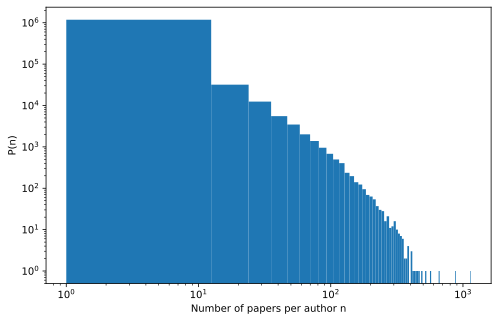

In [7]:
# We rank the simplices by their number of occurrences
fig, ax = plt.subplots(figsize=(8, 5))
occurr = df_i.groupby("Simplices").count()["Time"]
ax.hist(occurr, bins=100, log=True);
plt.xscale("log")
plt.xlabel("Number of papers per author n")
plt.ylabel("P(n)")

# Academic lifetime distribution

In [8]:
max_time = df_i.groupby("Simplices").max()["Time"].reset_index()
min_time = df_i.groupby("Simplices").min()["Time"].reset_index()

# We merge the two dataframes and compute the difference between the max and min time
time_diff = pd.merge(max_time, min_time, on="Simplices")
time_diff["diff"] = time_diff["Time_x"] - time_diff["Time_y"]

# We want the time_diff column in years
time_diff["diff"] = time_diff["diff"].apply(lambda x: x.days/365)

time_diff[time_diff["diff"] == np.max(time_diff["diff"])]["Simplices"]

39952      40234
735207    744608
Name: Simplices, dtype: int64

In [9]:
time_diff[time_diff["Simplices"] == 489377]

Simplices     Time_x     Time_y       diff
483716     489377 2015-01-01 1975-01-01  40.027397

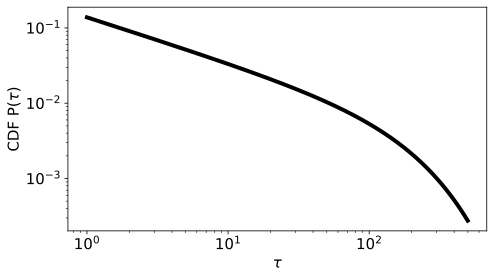

In [10]:
from scipy.special import gammaincc

def pdf(x,a,b):
    norm = (b**(a-1))*gammaincc(1-a,b)
    return (1/norm)*np.exp(-b*x)*x**(-a)

def cdf(x,a,b):
    norm = gammaincc(1-a,b)
    return (1/norm)*(gammaincc(1-a,b) - gammaincc(1-a,b*x))

a = 0.6
b = 0.005

fig, ax = plt.subplots(figsize=(7,4))

x_life = np.array([i for i in range(1,500)])
f_life = pdf(x_life,a,b)
plt.loglog(x_life,f_life,color="black",linestyle="-",linewidth=4)

plt.ylabel("CDF P("+r"$\tau$"+")",fontsize=15)
plt.xlabel(r"$\tau$",fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()

Text(0, 0.5, '$P(\\Delta t)$')

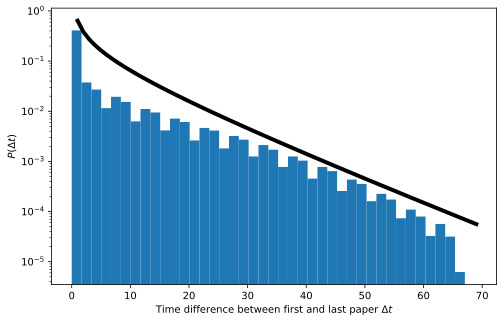

In [11]:
# And we plot the distribution of the time difference
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(time_diff["diff"], bins=40, log=True, density=True);
a = 0.6
b = 0.1

x_life = np.array([i for i in range(1,70)])
f_life = pdf(x_life,a,b)
plt.plot(x_life,f_life,color="black",linestyle="-",linewidth=4)
ax.set_xlabel(r"Time difference between first and last paper "+r"$\Delta t$")
ax.set_ylabel(r"$P(\Delta t)$")

In [12]:
### Academic age distribution



### Burstines

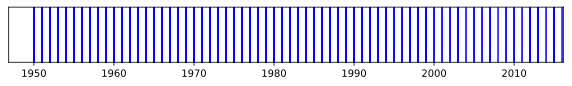

In [13]:
# Now we want for an simplicial to plot his carrer
fig, ax = plt.subplots(figsize=(10, 1))

for author_id in df_i["Simplices"][0:1000]:
    for j in df_i[df_i["Simplices"]==author_id]["Time"]:
        plt.axvline(x=j, color="blue", alpha=0.2)

ax.yaxis.set_visible(False)

In [14]:
# Now I want to consider the different simplicial sizes and how HOIs are related with the burstiness
df["Size"] = df["Simplices"].apply(lambda x: len(x))

df_j = df.explode("Simplices").reset_index()
df_j['Time'] = pd.to_datetime(df_j['Time'], format='%Y')
df_j = df_j.sort_values(by='Time')
df_j["Simplices"] = df_j["Simplices"].astype(int)

C:\Users\david\AppData\Local\Temp\ipykernel_2940\1225264548.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
C:\Users\david\AppData\Local\Temp\ipykernel_2940\1225264548.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Simplicial size")


Maximum simplicial size:  25


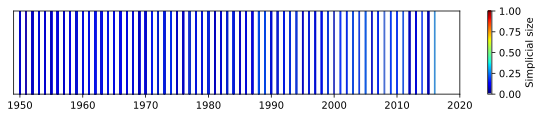

In [15]:
# Now we want for an simplicial to plot his carrer
fig, ax = plt.subplots(figsize=(10, 1.5))

cmap = plt.cm.get_cmap('jet')

size_max = df_j["Size"].max()
# Just the 1000 first authors to avoid large computation time
for author_id in df_j["Simplices"][0:1000]:
    for time, size in zip(df_j[df_j["Simplices"]==author_id]["Time"], df_j[df_j["Simplices"]==author_id]["Size"]):
        plt.axvline(x=time, color=cmap(size/size_max), alpha=0.2)
        
ax.yaxis.set_visible(False)
ax.set_xlim([datetime.date(1949, 1, 1), datetime.date(2020, 1, 1)])

plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Simplicial size")
print("Maximum simplicial size: ", size_max)

C:\Users\david\AppData\Local\Temp\ipykernel_2940\3478613812.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')
C:\Users\david\AppData\Local\Temp\ipykernel_2940\3478613812.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="log(size)")


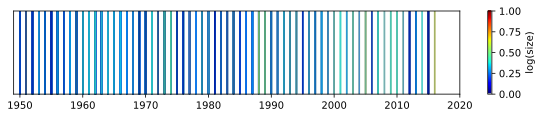

In [16]:
# Now we want for an simplicial to plot his carrer
fig, ax = plt.subplots(figsize=(10, 1.5))

cmap = plt.cm.get_cmap('jet')

size_max = np.log(df_j["Size"].max())
# Just the 1000 first authors to avoid large computation time
for author_id in df_j["Simplices"][0:1000]:
    for time, size in zip(df_j[df_j["Simplices"]==author_id]["Time"], df_j[df_j["Simplices"]==author_id]["Size"]):
        plt.axvline(x=time, color=cmap(np.log(size)/size_max), alpha=0.2)
        
ax.yaxis.set_visible(False)
ax.set_xlim([datetime.date(1949, 1, 1), datetime.date(2020, 1, 1)])

plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="log(size)")

In [25]:
# Now we want for an simplicial to plot his carrer
fig, ax = plt.subplots(4,1,figsize=(8, 4))

cmap = plt.cm.get_cmap('jet')

size_max = 15

# Just the 1000 first authors to avoid large computation time
k = 0
for author_id in df_j["Simplices"][0:50000]:
    for time, size in zip(df_j[df_j["Simplices"]==author_id]["Time"], df_j[df_j["Simplices"]==author_id]["Size"]):
        if size < 3 and size > 1:
            ax[0].axvline(x=time, color="blue", alpha=0.2)
            ax[0].set_title("1 - simplex")
        elif size < 7 and size > 5:
            ax[1].axvline(x=time, color="orange", alpha=0.2)
            ax[1].set_title("5 - simplex")
        elif size < 12 and size > 10:
            ax[2].axvline(x=time, color="green", alpha=0.2)
            ax[2].set_title("10 - simplex")
        elif size < 17 and size > 15:
            ax[3].axvline(x=time, color="green", alpha=0.2)
            ax[3].set_title("15 - simplex")
    
for i in range(0,len(ax)):
    ax[i].yaxis.set_visible(False)
    ax[i].set_xlim([datetime.date(1949, 1, 1), datetime.date(2016, 1, 1)])
    
fig.tight_layout()
plt.savefig("./Burstiness_adds.png", dpi=400)

C:\Users\david\AppData\Local\Temp\ipykernel_2940\860759537.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


### Is burstiness different for each each kid of simplicial 